## Expert Knowledge Worker

### A question answering agent that is an expert knowledge worker
### To be used by employees of Insurellm, an Insurance Tech company
### The agent needs to be accurate and the solution should be low cost.

This project will use RAG (Retrieval Augmented Generation) to ensure our question/answering assistant has high accuracy.

In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [2]:
# imports for langchain
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma

In [3]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

In [4]:
from langchain_classic.memory import ConversationBufferMemory
from langchain_classic.chains import ConversationalRetrievalChain

In [5]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "gpt-5-nano"
db_name = "vector_db"

In [6]:
# Load environment variables in a file called .env

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [7]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("knowledge-base/*")

# With thanks to CG and Jon R, students on the course, for this fix needed for some users 
text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

In [8]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [9]:
len(chunks)

413

In [10]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: contracts, products, employees, company


## A sidenote on Embeddings, and "Auto-Encoding LLMs"

We will be mapping each chunk of text into a Vector that represents the meaning of the text, known as an embedding.

OpenAI offers a model to do this, which we will use by calling their API with some LangChain code.

This model is an example of an "Auto-Encoding LLM" which generates an output given a complete input.
It's different to all the other LLMs we've discussed today, which are known as "Auto-Regressive LLMs", and generate future tokens based only on past context.

Another example of an Auto-Encoding LLMs is BERT from Google. In addition to embedding, Auto-encoding LLMs are often used for classification.

### Sidenote

In week 8 we will return to RAG and vector embeddings, and we will use an open-source vector encoder so that the data never leaves our computer - that's an important consideration when building enterprise systems and the data needs to remain internal.

In [11]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite

# embeddings = OpenAIEmbeddings()

# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Delete if already exists

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18776\2429844981.py:10: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Vectorstore created with 413 documents


In [12]:
# Get one vector and find how many dimensions it has

collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")

The vectors have 384 dimensions


## Visualizing the Vector Store

Let's take a minute to look at the documents and their embedding vectors to see what's going on.

In [13]:
# Prework

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
doc_types = [metadata['doc_type'] for metadata in result['metadatas']]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

C:\Users\Lenovo\anaconda3\envs\llms\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


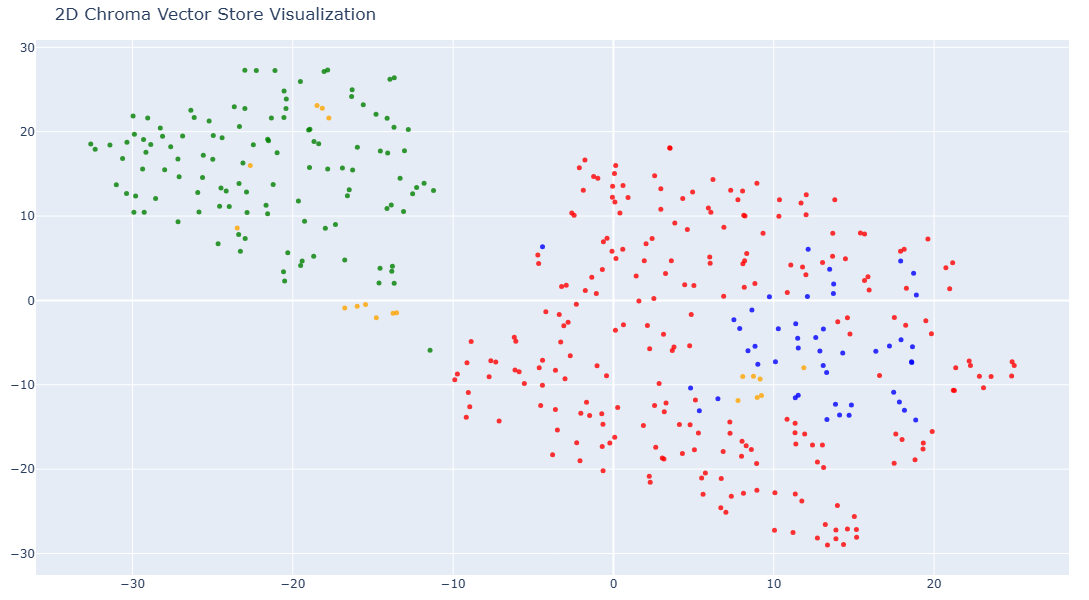

In [14]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

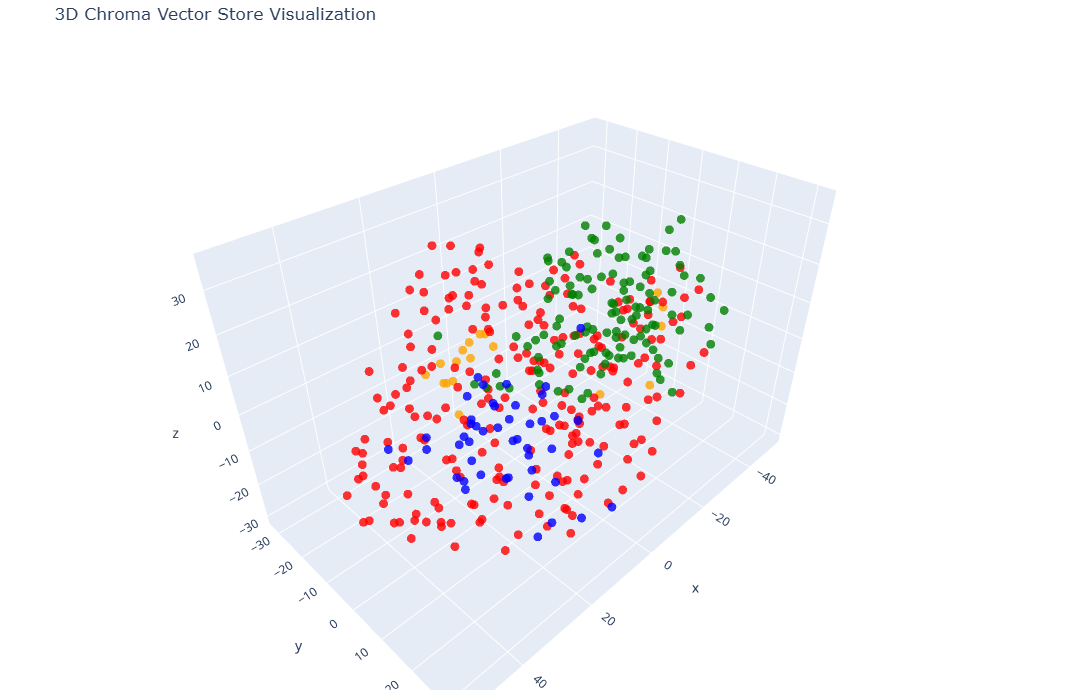

In [15]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

# Time to use LangChain to bring it all together

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../important.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#900;">PLEASE READ ME! Ignoring the Deprecation Warning</h2>
            <span style="color:#900;">When you run the next cell, you will get a LangChainDeprecationWarning 
            about the simple way we use LangChain memory. They ask us to migrate to their new approach for memory. 
            I feel quite conflicted about this. The new approach involves moving to LangGraph and getting deep into their ecosystem.
            There's a fair amount of learning and coding in LangGraph, frankly without much benefit in our case.<br/><br/>
            I'm going to think about whether/how to incorporate it in the course, but for now please ignore the Depreciation Warning and
            use the code as is; LangChain are not expected to remove ConversationBufferMemory any time soon.
            </span>
        </td>
    </tr>
</table>

## Alternative: to use a free open-source model instead of OpenAI in the next cell

First run this in a cell: `!pip install langchain-ollama`

Then replace `llm = ChatOpenAI(temperature=0.7, model_name=MODEL)` with:

```python
from langchain_ollama import ChatOllama
llm = ChatOllama(temperature=0.7, model="llama3.2")
```

In [16]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18776\3183950975.py:5: LangChainDeprecationWarning:

Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/



In [17]:
query = "Can you describe Insurellm in a few sentences"
result = conversation_chain.invoke({"question":query})
print(result["answer"])

Insurellm is a US-based insurance tech company founded in 2015 by Avery Lancaster. It builds modern insurance software platforms for auto, home, life, health, and commercial lines—carllm, homellm, lifellm, healthllm, and bizllm—with Lifellm featuring AI-powered underwriting. The company began with Markellm and later expanded to Carllm, Homellm, and Rellm, and today emphasizes lean, profitable growth and operational excellence. It operates with a distributed workforce of about 32 remote employees and has HQ in San Francisco with offices in New York, Austin, Chicago, and Denver.


In [18]:
# set up a new conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the GPT 5 nano LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

## Now we will bring this up in Gradio using the Chat interface -

A quick and easy way to prototype a chat with an LLM

In [19]:
# Wrapping in a function - note that history isn't used, as the memory is in the conversation_chain

def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]

In [20]:
# And in Gradio:

view = gr.ChatInterface(chat).launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## GEMINI

In [27]:
load_dotenv(override=True)
api_key =  os.getenv("GOOGLE_API_KEY")
if not api_key:
    print("API Key not found!")
else:
    print("API Key loaded in memory")


API Key loaded in memory


In [28]:
# create a new Chat with OpenAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",  # Gemini model name
    temperature=0.7,
)


# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the gemini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]



In [29]:
view_gemini = gr.ChatInterface(chat).launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


## Local LLM

In [ ]:
import requests
from openai import OpenAI
requests.get("http://localhost:11434").content
OLLAMA_BASE_URL = "http://localhost:11434/v1"
ollama = OpenAI(base_url=OLLAMA_BASE_URL, api_key='ollama')

In [36]:
# create a new Chat with OpenAI
from langchain_ollama import ChatOllama
llm = ChatOllama(temperature=0.7, model="llama3.2")

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the GPT 5 nano LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)
# putting it together: set up the conversation chain with the gemini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]

In [37]:
view_ollama = gr.ChatInterface(chat).launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


## Model dropdown

In [52]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.chat_models import ChatOllama
from langchain_classic.chains import ConversationalRetrievalChain

MODELS = [
    "gpt-5-nano",
    "gemini-2.5-flash-lite",
    "qwen2.5",
    "deepseek",
    "llama3.2",
]

def get_llm(model_name):
    if model_name == "gpt-5-nano":
        return ChatOpenAI(
            model="gpt-5-nano",
            temperature=0.7
        )
    elif model_name == "gemini-2.5-flash-lite":
        return ChatGoogleGenerativeAI(
            model="gemini-2.5-flash-lite",
            temperature=0.7
        )
    else:
        # Ollama models
        return ChatOllama(
            model=model_name,
            temperature=0.7
        )

In [53]:
# Global dictionary to store conversation chains for each model
# Global dictionary to store conversation chains for each model
conversation_chains = {}

def get_conversation_chain(model_name):
    """Get or create a conversation chain for the specified model"""
    if model_name not in conversation_chains:
        llm = get_llm(model_name)
        memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)
        retriever = vectorstore.as_retriever()
        conversation_chains[model_name] = ConversationalRetrievalChain.from_llm(
            llm=llm, 
            retriever=retriever, 
            memory=memory
        )
    return conversation_chains[model_name]

def chat(message, history, model_name):
    """Chat function that takes message, history, and selected model"""
    conversation_chain = get_conversation_chain(model_name)
    result = conversation_chain.invoke({"question": message})
    return result["answer"]


In [54]:
# Create Gradio interface with dropdown
with gr.Blocks() as demo:
    gr.Markdown("# RAG Chat with Multiple Models")
    
    with gr.Row():
        model_dropdown = gr.Dropdown(
            choices=MODELS,
            value=MODELS[0],
            label="Select Model",
            interactive=True
        )
    
    chatbot = gr.ChatInterface(
        fn=chat,
        additional_inputs=[model_dropdown],
        title="",
        examples=[
            ["What is this document about?", MODELS[0]],
            ["Summarize the main points", MODELS[0]],
            ["What are the key findings?", MODELS[0]]
        ]
    )

demo.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.
